In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100

import geopandas as gpd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


from os import listdir
import unicodedata


from paths import *
from scripts.io import read_sheets
from scripts import io


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

from IPython.display import IFrame


import yaml
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)


# Brasil.IO

In [2]:
from scripts import io

brio, brio_raw = io.load_brasilIO()

print("Br.IO table, Done!")

Br.IO table, Done!


In [3]:
brio

,city_ibge_code,city,confirmed,deaths,date,state
298584,4124301.0,Santo Antônio do Paraíso,1,0,2020-07-02,PR
313154,5000252.0,Alcinópolis,2,0,2020-07-05,MS
313155,5000609.0,Amambai,24,2,2020-07-05,MS
313156,5000708.0,Anastácio,5,1,2020-07-05,MS
313157,5000856.0,Angélica,9,0,2020-07-05,MS
...,...,...,...,...,...,...
326859,3500600.0,Águas de São Pedro,9,0,2020-07-07,SP
326860,3501202.0,Álvares Florence,8,0,2020-07-07,SP
326861,3501301.0,Álvares Machado,67,1,2020-07-07,SP
326862,3501400.0,Álvaro de Carvalho,3,2,2020-07-07,SP


## WCota
 - [github](https://github.com/wcota/covid19br)

In [27]:
# #data https://github.com/wcota/covid19br
# dd = io.load_wcota()


## MYTABLE

In [28]:
from scripts.io import read_sheets
from scripts import manipulation
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

# io.update_ms_data()

df = pd.read_csv("../data/ministerio_da_saude/last_data_ms_covid19.csv")


df = df.drop_duplicates(subset = ['regiao', 'estado', 'data', 'casosAcumulado', 'obitosAcumulado', 'last_update'])


df_states = manipulation.manipule_mytable(df,config['ms_table'])


In [29]:
vale = read_sheets('covid19_vale_do_paraiba_e_litoral_norte').replace('',0)
print("Vale table, Done!")

Vale table, Done!


In [30]:
br = io.load_total_table()
br = manipulation.create_all_country_total_data(br, vars = ['confirmed','deaths','recovered','active'])

In [31]:
br.head()

,date,countrycode,countryname,population,confirmed,new_confirmed,deaths,new_deaths,recovered,new_recovered,active,new_active
29205,2020-01-20,KW,Kuwait,4420110.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
30705,2020-01-20,NZ,New Zealand,4972468.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
30765,2020-01-20,NI,Nicaragua,6460411.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
30825,2020-01-20,NE,Niger,22314743.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
30885,2020-01-20,NG,Nigeria,206139587.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0


### GRAPHS

[Local - Indicator Model](file:///mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/covid19/images/storage/br_indicator_model.html)

[Local - Indicator Final](file:///mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/covid19/images/storage/br_indicator_final.html)

[GS-Indicator_Final](https://storage.googleapis.com/sv-covid19/brasil/br_indicator_final.html)

In [32]:
from scripts import vis_html

config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

vis_html.create_cards(df_states,vale, br ,config['embed_html'])


#     io.to_storage(bucket='sv-covid19',
#               bucket_folder='site/full',
#               file_name=files[model],
#               path_to_file=path+files[model])
    
# print("Embed link uploaded")

Embed html uploaded!


## Cumulativo

In [33]:
from scripts import vis_graphs

themes = yaml.load(open('../themes/custom_colorscales.yaml', 'r'), Loader=yaml.FullLoader)
themes = themes['brasil_vis_cumulative']

for var in themes['vars'].keys():
    for scale in themes['axis_legend']['scale'].keys():
        fig = vis_graphs.brasil_vis_cum(df_states, var,scale, themes)
        
        plot(fig, filename=f"../site/sv_br_vale/coronavirus/images/cumulative/brasil_por_estado_{var}.html", auto_open=False)


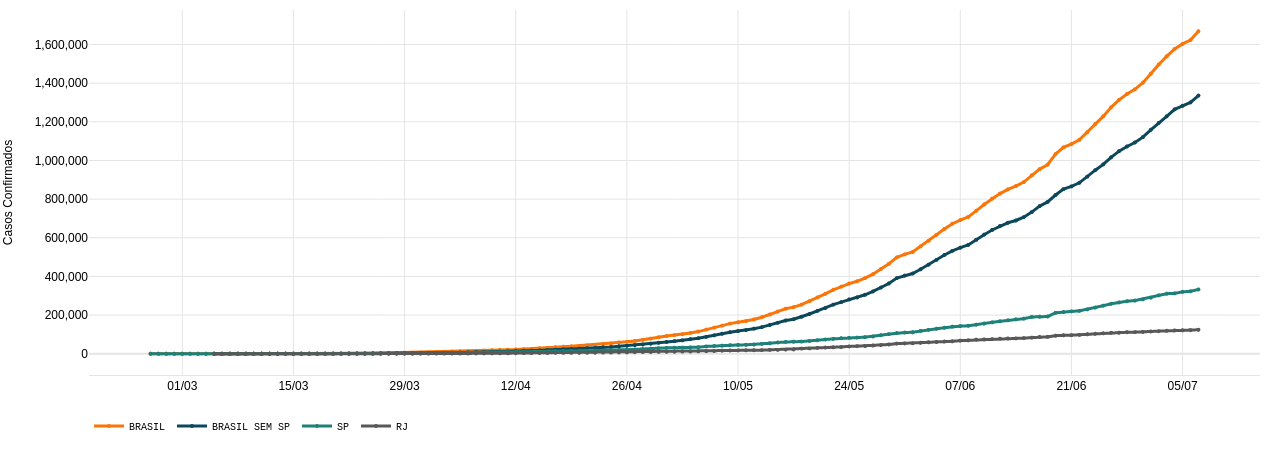

In [34]:
fig

## Diario

In [35]:
themes = yaml.load(open('../themes/custom_colorscales.yaml', 'r'), Loader=yaml.FullLoader)
themes = themes['brasil_vis_daily']

codes = ['BRASIL','SP']

for state in codes:
    mask = ((df_states['state']==state) & (df_states['confirmed']>0))
    fig = vis_graphs.unique_country(df_states[mask], themes)

    plot(fig, filename=f"../site/sv_br_vale/coronavirus/images/daily/{state}.html", auto_open=False)


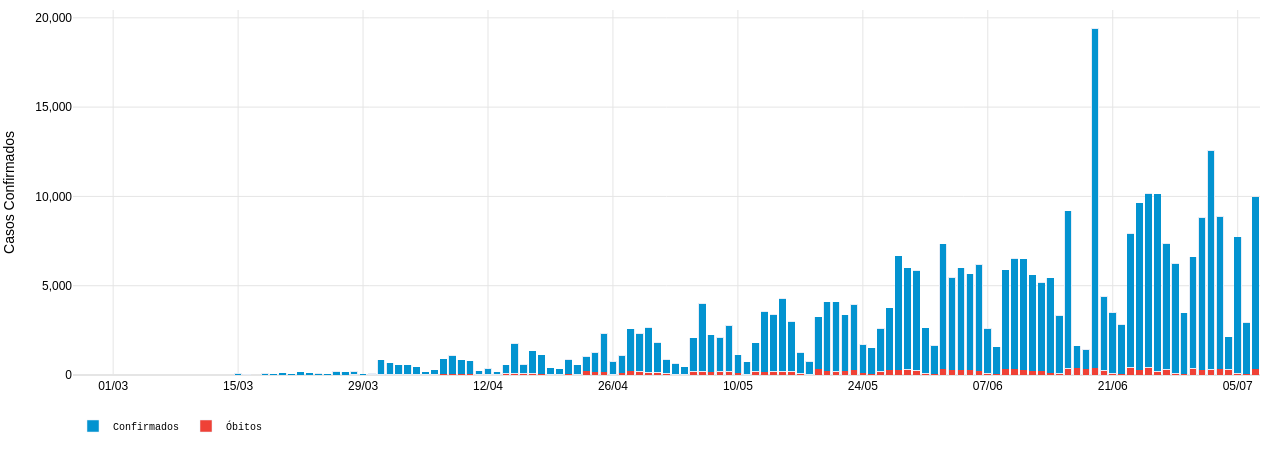

In [36]:
fig

## MAPS

In [37]:
def _generate_and_upload_br_map(final, estados, map_config):
    #generate map
    cols = ['Município','Estado','Confirmados', 'Óbitos', 'Data do Boletim']
    
    print('Generate and save br map..')
    mymap =  vis_maps.get_map(final,'Confirmados', cols, estados)
    mymap.save(f'{map_config["path_save"]}{map_config["save_name"]}')

    print('Upload br map..')
    io.to_storage(bucket=map_config['bucket'],
              bucket_folder=map_config['bucket_folder'],
              file_name=map_config['save_name'],
              path_to_file=f'{map_config["path_save"]}{map_config["save_name"]}')
    
    os.remove(f'{map_config["path_save"]}{map_config["save_name"]}')

In [38]:
print('Start Br Map')
#minicipales data
municipios = pd.read_csv('../data/br_municipios_ibge.csv', dtype={'geocodigo':str})
df = brio.copy()

#load shape files;
ufs = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')
maps = gpd.read_file('../../mapas_brasil/municipios-ibge/brasil-municipios.shp')

Start Br Map


In [39]:
from scripts import manipulation
from scripts import vis_maps

config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

#prepare data for map
final, estados = manipulation.manipulate_for_br_maps(brio, municipios, maps, df_states.drop(['regiao'],1), ufs)

# _generate_and_upload_br_map(final, estados, config['br_map'])

## Vale

In [40]:
def _generate_and_upload_vale_map(vale, estados, map_config):
    #generate map
    cols = list(config['vale_map']['col_rename'].values())
    cols.remove('Fonte')
    
    print('Generate and save vale map..')
    mymap =  vis_maps.get_map_vale(vale,'Confirmados', cols, estados)
    mymap.save(f'{map_config["path_save"]}{map_config["save_name"]}')

    print('Map Done!')
#     io.to_storage(bucket=map_config['bucket'],
#               bucket_folder=map_config['bucket_folder'],
#               file_name=map_config['save_name'],
#               path_to_file=f'{map_config["path_save"]}{map_config["save_name"]}')
    
#     os.remove(f'{map_config["path_save"]}{map_config["save_name"]}')
#     return(mymap)

In [41]:

from scripts.io import read_sheets
from scripts import manipulation
#download and manipulate vale data
df = read_sheets('covid19_vale_do_paraiba_e_litoral_norte')
df = manipulation.manipulate_vale_data(df)

#load shape files
municipios_sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
ufs = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')


In [42]:
## Manipulate data for generate map
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

vale, estados = manipulation.manipulate_for_vale_maps(df, municipios_sp, estados,config['vale_map'])

_generate_and_upload_vale_map(vale, estados, config['vale_map'])


Generate and save vale map..
Map Done!


In [43]:
#https://pypi.org/project/ftpretty/
from ftpretty import ftpretty
import ftplib
import yaml
import os
credentials = yaml.load(open('../../credentials/ftp_credentials.yaml', 'r'), Loader=yaml.FullLoader)


In [44]:
host = credentials['ftp']['host']
user = credentials['ftp']['user']
pw   = credentials['ftp']['pw']

f = ftpretty(host, user, pw)

### Upload sv site

In [45]:
%%time
local_folder  = '../site/sv_br_vale/coronavirus'
remote_folder = 'public_html/coronavirus'

f.upload_tree(local_folder, remote_folder)

CPU times: user 79.7 ms, sys: 110 ms, total: 189 ms
Wall time: 2min 24s


'public_html/coronavirus'

# Corona SP

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/seade-R/dados-covid-sp/master/data/dados_covid_sp.csv', sep=';')

In [8]:
df['date'] = '2020-' + df['mes'].astype(str) + '-' + df['dia'].astype(str)

df['date'] = pd.to_datetime(df['date'])

In [20]:
df = df.sort_values(by=['munic','date'],ascending=True).drop(['dia','mes'],1)

In [25]:
mask = df['munic']=='taubate'
# df[mask]
